# HW1 1 313511068 練鈞揚

## Part 1 N gram

In [67]:
from collections import defaultdict
from tqdm import tqdm
from rich import print
import psutil
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
def display_ram_usage():
    """获取并显示当前的内存使用情况。"""
    ram = psutil.virtual_memory()
    total_ram = ram.total / (1024 ** 3)  # 总内存 (GB)
    used_ram = ram.used / (1024 ** 3)    # 已用内存 (GB)
    percentage_used = ram.percent  # 已用内存百分比
    return total_ram, used_ram, percentage_used

In [69]:

class N_grams:
    def __init__(self,n:int):
        self._n = n + 1
        self._model = defaultdict(lambda: defaultdict(int))
        return 
    
    def _generate_n_grams(self, text:str)->list[str]:
        tokens = list(text.split(" "))
        n_grams = [tokens[i:i+self._n] for i in range(len(tokens) - self._n + 1)]
        return n_grams 
    
    def train(self, corpus_list:list[str]):
        for corpus in tqdm(corpus_list,desc="Training",unit="line", dynamic_ncols=True, leave=True):
            ngrams = self._generate_n_grams(corpus)
            
            for ngram in ngrams:    
                prefix = tuple(ngram[:-1])
                next_word = ngram[-1]
                
                self._model[prefix][next_word] += 1
        return 
    
    def predict(self, prefix:list[str]):
        if tuple(prefix) not in self._model:
            return None
        prefix_key = tuple(prefix)
        next_word = max(self._model[prefix_key], key=self._model[prefix_key].get)
        
        return next_word

    def predict_all(self, prefix:list[str], num:int)-> list[str]:
        res = prefix
        n = self._n - 1
        for _ in range(num):
            res.append(self.predict(res[-n:]))
        
        return res
    
    def test_model(self, corpus_list:list[str] , output_file_name:str)-> dict:
        total_predictions = 0
        correct_predictions = 0
        
        data = {"Acc(%)":[] , "Ram Usage(%)":[]}
        
        # Generate n-grams from test corpus and predict next words
        for corpus in tqdm(corpus_list, desc="Testing",unit="line", dynamic_ncols=True, leave=True):
            ngrams = self._generate_n_grams(corpus)
            
            for ngram in ngrams:
                prefix = ngram[:-1]  # (n-1)-gram前缀
                actual_next_word = ngram[-1]  # 真实的下一个词
                
                predicted_next_word = self.predict(prefix)
                
                if predicted_next_word == actual_next_word:
                    correct_predictions += 1
                
                total_predictions += 1
                
            total_ram, used_ram, percentage_used = display_ram_usage()
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
            # 更新进度条的后缀
            
            data["Ram Usage(%)"].append(percentage_used)
            data["Acc(%)"].append(accuracy * 100)
                

                
        df = pd.DataFrame(data)

        # Step 2: Plot the data using pandas DataFrame's plot method
        ax = df.plot()

        # Step 3: Customize the plot
        ax.set_title(f'{self._n -1} gram memory usage and acc')
        ax.set_xlabel('index')
        ax.set_ylabel('%')
        ax.grid(True)

        # Step 4: Save the plot as an image file
        plt.savefig(output_file_name, dpi=300, bbox_inches='tight')  # Save the figure
        
        # Calculate accuracy
        
        return data

## Load data

In [70]:
with open("./train.txt" , mode="r") as f_train, open("./test.txt", mode="r") as f_test:
    train_data = [line.strip() for line in f_train.readlines()]
    test_data =  [line.strip() for line in f_test.readlines()]
    

## Build model

In [71]:
model_2 = N_grams(2)

In [72]:
model_3 = N_grams(3)

In [73]:
model_2.train(train_data)

Training: 100%|██████████| 2599668/2599668 [00:10<00:00, 239971.82line/s]


In [74]:
model_3.train(train_data)

Training:   0%|          | 0/2599668 [00:00<?, ?line/s]

Training: 100%|██████████| 2599668/2599668 [00:12<00:00, 208881.30line/s]


Testing: 100%|██████████| 649918/649918 [01:41<00:00, 6386.98line/s]


35.71754738420279

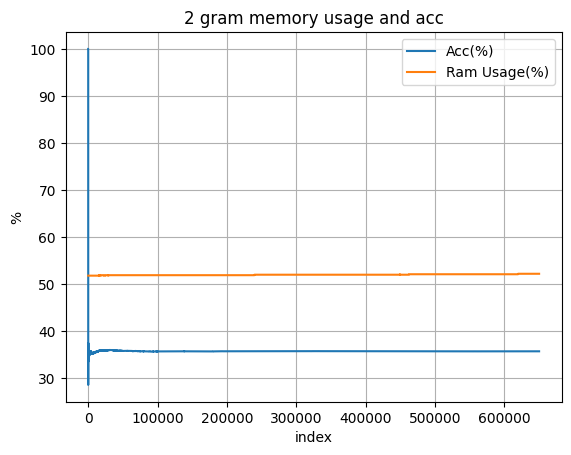

In [9]:
res_2 = model_2.test_model(test_data, output_file_name="res2.png")
print(res_2["Acc(%)"][-1])

Testing: 100%|██████████| 649918/649918 [00:38<00:00, 16666.52line/s]


36.58432955673828

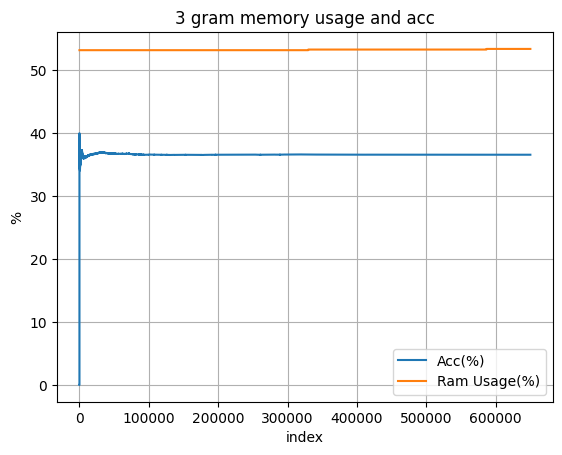

In [10]:
res_3 = model_3.test_model(test_data, output_file_name="res3.png")
print(res_3["Acc(%)"][-1])

## Report on Hardware and N-gram Model Performance

In N-gram models, the choice of `n` (the number of words grouped together) significantly influences both model accuracy and resource usage. As `n` increases, such as moving from a 2-gram to a 3-gram model, both RAM usage and prediction accuracy rise due to the increased context and data required to maintain larger groups of words.

A 3-gram model uses more RAM than a 2-gram model, as it needs to store and access a larger number of word combinations. This additional memory usage enables the model to capture richer contextual information, as a 3-gram model considers three-word sequences rather than two. Consequently, this results in a higher prediction accuracy for 3-gram models, as they have a broader context for predicting the next word. This makes the 3-gram model more suitable for tasks involving nuanced language modeling and word prediction, despite the increased memory requirement.

## incomplete 

In [75]:
with open("./incomplete.txt", mode="r") as f:
    data = [line.strip() for line in f.readlines()]

In [83]:
res = [model_2.predict_all(item.split(" "), num=20) for item in data]
res = [' '.join(item ) for item in res]
print(res)

[
    'cover with foil and bake for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'roll up and place in a large bowl and mix well and set aside to cool completely on wire rack to cool',
    'cook the pasta and cook for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'stir in the center of the pan and bake for about 5 minutes or until the mixture into the pan and bake',
    'spread out on a baking sheet and bake for about 5 minutes or until the mixture into the pan and bake for',
    'transfer the mixture into the pan and bake for about 5 minutes or until the mixture into the pan and bake 
for',
    'put the chicken and cook for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'push the dough into a large bowl and mix well and set aside to cool completely on wire rack to cool 
completely',
    'cut into squares and serve with a fork and serve with a fork and serve with a fork and serve with a',
    'toss the salad and toss to coat the bottom of the pan and bake for about 5 minutes or until the mixture'
]

## Part 2 RNN

In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import lightning as L
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from lightning.pytorch.loggers import TensorBoardLogger
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from lightning.pytorch.callbacks import ModelCheckpoint
import re
from collections import defaultdict, Counter
from typing import Callable
from natsort import natsorted

torch.set_float32_matmul_precision("high")

In [2]:
@dataclass
class Lib:
    word2idx: dict[str, int]
    idx2word: dict[int, str]
    size: int

    def word_2_index(self, word: str) -> int:
        return self.word2idx.get(word, self.word2idx["<UNK>"])  # "<UNK>"

    def index_2_word(self, index: int) -> str:
        return self.idx2word.get(index, " ")

    @staticmethod
    def natural_split(text: str, no_symbol: bool = True) -> list[str]:
        pattern = r"([a-zA-Z0-9]+|[^\s\w]|[\s]+)" if not no_symbol else r"[a-zA-Z0-9]+"
        result = re.findall(pattern, text)
        return result

    @classmethod
    def build_from_text(cls, str_list: list[str]):
        group = " ".join(str_list)
        vocab = set(
            Lib.natural_split(group, False)
            + ["<START>", "<END>", "<PAD>", "<UNK>"]  # ,
        )

        vocab = natsorted(vocab)

        word2idx = {
            word: i
            for i, word in tqdm(enumerate(vocab), desc="build word 2 idx", unit="word")
        }
        idx2word = {
            idx: word
            for word, idx in tqdm(word2idx.items(), desc="build idx 2 word", unit="idx")
        }

        return cls(word2idx, idx2word, len(word2idx))

    @classmethod
    def build_from_file(cls, filename: str):
        with open(filename, "r") as f:
            data = [item.strip() for item in f.readlines()]
        return cls.build_from_text(data)

    def sentence_to_idx_tensor(self, sentence: list[str]):
        return torch.tensor(
            [self.word_2_index(word) for word in sentence], dtype=torch.long
        )

    def word_to_tensor(self, word: str) -> torch.Tensor:
        tensor = torch.zeros(self.size)
        index = self.word_2_index(word)

        tensor[index] = 1
        return tensor

    def tensor_to_sentence(self, tensor: torch.Tensor) -> str:
        return " ".join([self.index_2_word(int(item)) for item in tensor])

    def __len__(self) -> int:
        return self.size


## Build a dataset

In [3]:
class TextDataset(Dataset):
    def __init__(
        self, sentences: str, n_list: int, text_lib: Lib, train_mode: bool = True
    ):
        self.n_list = n_list
        self.text_lib = text_lib
        self.data = TextDataset.process_data(sentences, n_list, train_mode)
        return

    @staticmethod
    def gen_process_data(sentences: str, n_list: list[int]):
        for n in n_list:
            for sentence in tqdm(
                sentences,
                desc=f"process({n})",
                unit="line",
                dynamic_ncols=True,
                leave=True,
            ):
                line = Lib.natural_split(sentence)

                line = ["<START>"] + line + ["<END>"] + ["<PAD>"] * (n - len(line))

                for i in range(len(line) - n):
                    input_str = line[i : i + n]
                    target_str = line[i + n]

                    yield tuple(input_str), target_str

    @staticmethod
    def process_data(sentences: str, n_list: list[int], train_mode: bool):
        if not train_mode:
            data = [
                (input_str, target_str)
                for input_str, target_str in TextDataset.gen_process_data(
                    sentences, n_list
                )
            ]
            return data

        # train mode
        data_dict = defaultdict(list)

        for input_str, target_str in TextDataset.gen_process_data(sentences, n_list):
            k, v = input_str, target_str

            data_dict[k].append(v)

        for k in tqdm(
            data_dict.keys(),
            desc="counting",
            unit="pair",
            dynamic_ncols=True,
            leave=True,
        ):
            large_word = Counter(data_dict[k]).most_common(1)
            data_dict[k] = large_word[0][0]

        return list(data_dict.items())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        input_str, target_str = self.data[index]
        input_tensor = self.text_lib.sentence_to_idx_tensor(input_str)
        target_tensor = self.text_lib.sentence_to_idx_tensor([target_str])
        return input_tensor, target_tensor

    @classmethod
    def build_from_file(
        cls,
        filename: str,
        n_list: int,
        lib: Lib = None,
        train_mode: bool = False,
        filter_: Callable = None,
    ):
        with open(file=filename, mode="r") as f:
            data = [line.strip() for line in f.readlines()]

        if filter_ is not None:
            data = list(filter(filter_, data))

        if lib is None:
            lib = Lib.build_from_text(data)

        return cls(data, n_list, lib, train_mode)

## RNN Model


In [4]:
class RnnModel(L.LightningModule):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_size: int,
        output_size: int,
        num_layers=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=0.1,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.save_hyperparameters()
        return

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):

        input_tensor, target_tensor = train_batch
        target_tensor = target_tensor.squeeze(dim=1)

        output = self.forward(input_tensor)
        loss = F.cross_entropy(input=output, target=target_tensor)

        predicted_tensor = torch.argmax(output, dim=1)
        accuracy = (predicted_tensor == target_tensor).float().mean()

        self.log_dict(
            {"train_loss": loss, "tran_acc": accuracy},
            on_step=True,
            on_epoch=True,
            logger=True,
        )

        return loss

    def validation_step(self, val_batch, batch_idx):

        input_tensor, target_tensor = val_batch
        target_tensor = target_tensor.squeeze(dim=1)

        output = self.forward(input_tensor)
        loss = F.cross_entropy(input=output, target=target_tensor)

        predicted_tensor = torch.argmax(output, dim=1)
        accuracy = (predicted_tensor == target_tensor).float().mean()

        # Calculate perplexity
        log_probs = F.log_softmax(output, dim=-1)  # Get log probabilities
        target_log_probs = log_probs.gather(1, target_tensor.unsqueeze(-1)).squeeze(
            -1
        )  # Log probs for true targets
        avg_neg_log_prob = -target_log_probs.mean()  # Average negative log probability
        perplexity = torch.exp(avg_neg_log_prob)  # Calculate perplexity

        self.log_dict(
            {"val_loss": loss, "val_acc": accuracy, "val_perplexity": perplexity},
            on_step=True,
            on_epoch=True,
            logger=True,
        )

        return

    def test_step(self, test_batch, batch_idx, dataloader_idx=0):
        # Unpack test batch
        input_tensor, target_tensor = test_batch
        target_tensor = target_tensor.squeeze(dim=1)

        # Forward pass
        output = self.forward(input_tensor)
        loss = F.cross_entropy(input=output, target=target_tensor)

        predicted_tensor = torch.argmax(output, dim=1)
        accuracy = (predicted_tensor == target_tensor).float().mean()

        # Calculate perplexity
        log_probs = F.log_softmax(output, dim=-1)  # Get log probabilities
        target_log_probs = log_probs.gather(1, target_tensor.unsqueeze(-1)).squeeze(
            -1
        )  # Log probs for true targets
        avg_neg_log_prob = -target_log_probs.mean()  # Average negative log probability
        perplexity = torch.exp(avg_neg_log_prob)  # Calculate perplexity

        self.log_dict(
            {"test_loss": loss, "test_acc": accuracy, "test_perplexity": perplexity},
            on_step=True,
            on_epoch=True,
            logger=True,
        )

        return

    def predict_step(self, predict_batch, batch_idx):
        input_tensor, target_tensor = predict_batch
        target_tensor = target_tensor.squeeze(dim=1)

        output = self.forward(input_tensor)
        # loss = F.cross_entropy(input=output, target=target_tensor)

        predicted_tensor = torch.argmax(output, dim=1)
        # accuracy = (predicted_tensor == target_tensor).float().mean()

        return predicted_tensor

In [12]:
epoch = 10
batch_size = 32
number_of_layer = 2
hidden = 128
embedding_dim = 128
prefix_len = [2, 3, 9]
num_workers_train = 0
num_workers_test = 2

In [5]:
lib = Lib.build_from_file("./train.txt")

build word 2 idx: 38413word [00:00, 2950352.50word/s]
build idx 2 word: 100%|██████████| 38413/38413 [00:00<00:00, 4063757.65idx/s]


In [8]:
model = RnnModel(
    vocab_size=lib.size,
    embedding_dim=embedding_dim,
    hidden_size=hidden,
    output_size=lib.size,
    num_layers=number_of_layer,
)

In [9]:
print(model)

RnnModel(
  (embedding): Embedding(38412, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=38412, bias=True)
)


In [80]:
tb_logger = TensorBoardLogger("logs/")

In [81]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

In [82]:
trainer = L.Trainer(callbacks=[checkpoint_callback], logger=tb_logger, max_epochs=epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
train_dataset = TextDataset.build_from_file(
    "./train.txt",
    n_list=prefix_len,
    lib=lib,
    train_mode=True,
)

counting: 100%|██████████| 8556849/8556849 [00:19<00:00, 435758.17pair/s]


In [15]:
test_dataset = TextDataset.build_from_file(
    "./test.txt",
    n_list=[9],
    lib=lib,
    train_mode=False,
    filter_=lambda x: len(x.split(" ")) > 9,
)

process(9): 100%|██████████| 141131/141131 [00:00<00:00, 194743.59line/s]


In [16]:
print(f"Train : {len(train_dataset)}, Test : {len(test_dataset)}")

Train : 8556849, Test : 903096


In [31]:
def pad_collate(batch) -> tuple[torch.Tensor, torch.Tensor]:
    inputs, targets = zip(*batch)

    # 使用 PyTorch 的 pad_sequence 函数对输入进行填充
    inputs = pad_sequence(
        inputs, batch_first=True, padding_value=lib.word_2_index("<PAD>")
    )
    targets = pad_sequence(
        targets, batch_first=True, padding_value=lib.word_2_index("<PAD>")
    )

    return inputs, targets

In [79]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers_train,
    collate_fn=pad_collate,
)

In [32]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=5000,
    shuffle=False,
    num_workers=num_workers_test,
)

In [ ]:
trainer.fit(model, train_dataloader,test_dataloader,ckpt_path="last")

/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 8.1 M  | train
1 | rnn       | RNN       | 66.0 K | train
2 | fc        | Linear    | 8.1 M  | train
------------------------------------------------
16.3 M    Trainable params
0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 389838/389838 [1:06:06<00:00, 98.29it/s, v_num=1, train_loss_step=10.90, tran_acc_step=0.160] 

In [17]:
df_loss = pd.read_csv("./logs_csv/lightning_logs_version_3_loss.csv")
df_loss = df_loss.drop(columns=["Wall time","Step"])
df_loss = df_loss.rename(columns={"Value":"Training Loss"})
df_loss

,Training Loss
0,4.256882
1,3.341042
2,3.076217
3,2.944513
4,2.860073
5,2.799371
6,2.751592
7,2.713658
8,2.682947
9,2.656434


<Axes: title={'center': 'Training loss'}, xlabel='epoch', ylabel='loss'>

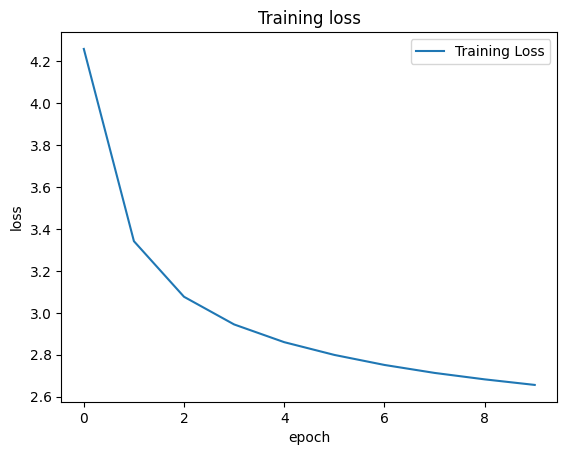

In [18]:
df_loss.plot(y="Training Loss",title="Training loss", ylabel="loss", xlabel="epoch")

In [19]:
df_acc = pd.read_csv("./logs_csv/lightning_logs_version_3_acc.csv")
df_acc = df_acc.drop(columns=["Wall time","Step"])
df_acc = df_acc.rename(columns={"Value":"Training Acc"})
df_acc

,Training Acc
0,0.368894
1,0.435935
2,0.460538
3,0.473758
4,0.482221
5,0.488294
6,0.492895
7,0.496335
8,0.499267
9,0.501644


<Axes: title={'center': 'Training acc'}, xlabel='epoch', ylabel='acc'>

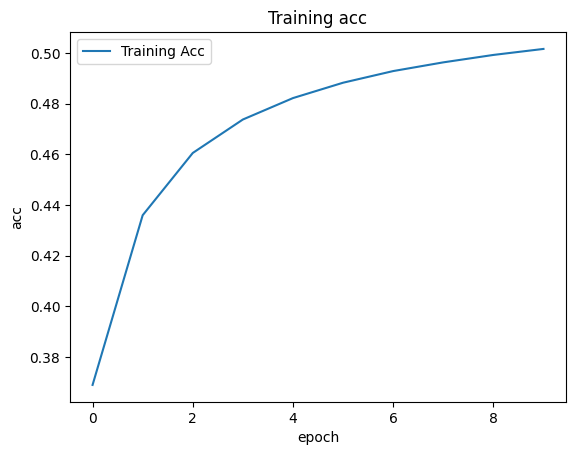

In [20]:
df_acc.plot(y="Training Acc",title="Training acc", ylabel="acc", xlabel="epoch")

## Check Rnn model in test acc

In [6]:
model_load = RnnModel.load_from_checkpoint(
    "./logs/lightning_logs/version_3/checkpoints/model-epoch=09-val_loss=3.10.ckpt",
)
print(model_load)

RnnModel(
  (embedding): Embedding(38413, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=38413, bias=True)
)


In [17]:
test_dataset_plus_2 = TextDataset.build_from_file(
    "./test.txt",
    n_list=[2],
    lib=lib,
    train_mode=False
)
test_dataset_plus_3 = TextDataset.build_from_file(
    "./test.txt",
    n_list=[3],
    lib=lib,
    train_mode=False
)
test_dataset_plus_4 = TextDataset.build_from_file(
    "./test.txt",
    n_list=[9],
    lib=lib,
    train_mode=False,
    filter_= lambda x: len(x.split(" ")) > 9, 
)

process(9): 100%|██████████| 141131/141131 [00:00<00:00, 187528.87line/s]


In [18]:
test_dataloader_plus_2 = DataLoader(test_dataset_plus_2, batch_size=5000, shuffle=False, num_workers=1)
test_dataloader_plus_3 = DataLoader(test_dataset_plus_3, batch_size=5000, shuffle=False, num_workers=1)
test_dataloader_plus_4 = DataLoader(test_dataset_plus_4, batch_size=5000, shuffle=False, num_workers=1)



In [19]:
trainer_plus = L.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
test_out = trainer_plus.test(model=model_load, dataloaders=[test_dataloader_plus_2,test_dataloader_plus_3,test_dataloader_plus_4], verbose=True)
print(test_out)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 2: 100%|██████████| 181/181 [00:16<00:00, 11.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.2914066016674042     │    0.3600669801235199     │    0.3780927062034607     │
│      test_loss_epoch      │     4.179619789123535     │    3.6791200637817383     │    3.5170347690582275     │
│   test_perplexity_epoch   │     65.45535278320312     │     39.70037078857422     │    33.771759033203125     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch/dataloader_idx_0': 4.179619789123535, 'test_acc_epoch/dataloader_idx_0': 0.2914066016674042, 'test_perplexity_epoch/dataloader_idx_0': 65.45535278320312}, {'test_loss_epoch/dataloader_idx_1': 3.6791200637817383, 'test_acc_epoch/dataloader_idx_1': 0.3600669801235199, 'test_perplexity_epoch/dataloader_idx_1': 39.70037078857422}, {'test_loss_epoch/dataloader_idx_2': 3.5170347690582275, 'test_acc_epoch/dataloader_idx_2': 0.3780927062034607, 'test_perplexity_epoch/dataloader_idx_2': 33.771759033203125}]


In [21]:
with open("./incomplete.txt", mode="r") as f:
    data = [line.strip() for line in f.readlines()]
print(data)

['cover with', 'roll up', 'cook the', 'stir in', 'spread out', 'transfer the', 'put the', 'push the', 'cut into', 'toss the']


In [22]:
def complete_string(prefix_list:list[str], lib:Lib, model:RnnModel, model_prefix:int, num:int)->str:    
    
    tensor_list = torch.stack([
        torch.cat([
            lib.sentence_to_idx_tensor(["<START>"] + prefix.split(" "))
        ])
        for prefix in prefix_list
    ]).to(model.device) 
    
    
    for _ in range(num):
        # get last 2 column        
        if tensor_list.shape[1] < model_prefix:
            input_tensor = tensor_list
        else:
            input_tensor = tensor_list[:, -model_prefix:]

        output_tensor = model(input_tensor)
        output_idx = torch.argmax(output_tensor, dim=1)
        
        output_idx = output_idx.unsqueeze(-1)
        tensor_list = torch.cat((tensor_list, output_idx), dim=1)
    
    output = [lib.tensor_to_sentence(row) for row in tensor_list]
    return output

In [23]:
output = complete_string(data, lib=lib, model=model_load, model_prefix=9, num=20)
output

['<START> cover with 001 02 cup of the sauce <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD> <PAD>',
 '<START> roll up to 001 04 inch thick <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD> <PAD> <PAD>',
 '<START> cook the onion until tender <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> stir in the remaining ingredients <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> spread out of the top of the cake <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD> <PAD>',
 '<START> transfer the back to a boil <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> put the rest of the chicken in the oven <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <END> <PAD> <PAD>',
 '<START> push the dough into a ball <END> <PAD> <PA

In [24]:
def extract_segments(lst):
    segments = []
    current_segment = []
    start_found = False

    for item in lst:
        if item == '<START>':
            current_segment = []
            start_found = True
        elif item == '<END>' and start_found:
            segments.append(' '.join(current_segment))
            start_found = False
        elif start_found:
            current_segment.append(item)

    return segments[0]

In [25]:
output_new = [extract_segments(item.split(" ")) for item in output]
output_new

['cover with 001 02 cup of the sauce',
 'roll up to 001 04 inch thick',
 'cook the onion until tender',
 'stir in the remaining ingredients',
 'spread out of the top of the cake',
 'transfer the back to a boil',
 'put the rest of the chicken in the oven',
 'push the dough into a ball',
 'cut into squares',
 'toss the mixture into a bowl']

## Comparative Report: RNN and N-gram Model Performance

### Model Complexity and Training Requirements
When comparing RNN and N-gram models, several distinctions in complexity and resource requirements become evident. The RNN model, due to its sequential nature and the additional embedding layer, requires significantly more data and computational power during training. In contrast, the N-gram model is comparatively lightweight, with shorter training times and minimal data requirements, making it a simpler but less nuanced choice. Additionally, while RNN training can be substantially accelerated with GPU support, the N-gram model can typically be trained efficiently on a CPU.

### Accuracy and Predictive Capabilities
The RNN model demonstrates higher accuracy than the N-gram model, largely due to the embedded layer, which enables the RNN to process inputs of varying lengths and capture more context around each word. This adaptability allows the RNN to make more accurate predictions on a broader range of language tasks, whereas the N-gram model, constrained by fixed-length sequences, is limited in its predictive ability and struggles with longer context dependencies.

### Perplexity Results: RNN vs. N-gram
Perplexity results highlight the RNN's advantage in language understanding. The RNN model achieves a substantially lower perplexity score compared to the N-gram model, indicating a higher probability assigned to correct next words. This suggests that the RNN can model language sequences with greater confidence, while the N-gram model exhibits higher perplexity, reflecting its limited contextual scope and lower predictive accuracy.

### Summary
In summary, while the N-gram model offers a faster, less resource-intensive option, the RNN’s higher accuracy and lower perplexity make it a stronger candidate for applications requiring nuanced language comprehension, provided sufficient computational resources and data are available.